## AI-Driven Cloud Resource Allocation  

---

## Abstract

Due to the exponential expansion of cloud computing, effective resource allocation has become essential. Conventional techniques struggle with dynamic workloads leading to over- or under-provisioning. This project investigates the integration of AI algorithms—including reinforcement learning and neural networks—to predict future workloads and dynamically adjust resource allocation. By employing an AI-driven mechanism, cloud platforms can improve performance, reduce costs, and scale resources in real time.

---

## Objectives

- **Understand the Problem:** Identify challenges in traditional cloud resource allocation.
- **Methodology:** Implement AI-driven resource allocation using reinforcement learning (RL) and neural networks (NN).
- **Demonstration:** Build a simulation environment to mimic dynamic resource allocation.
- **Analysis:** Visualize training rewards, resource utilization, and performance trends.


In [ ]:
# Install required packages (run this cell only once)
!pip install gym==0.26.2 tensorflow matplotlib


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 721.7/721.7 kB 7.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for gym: filename=gym-0.26.2-py3-none-any.whl size=827728 sha256=63bd450aa63608aa378f6089c38e0dc395589bf8e5d45dd13cbb3b532ce974f1
  Stored in directory: /root/.cache/pip/wheels/1c/77/9e/9af5470201a0b0543937933ee99ba884cd237d2faefe8f4d37
Successfully built gym
  Attempting uninstall: gym
    Found existing installation: gym 0.25.2
    Uninstalling gym-0.25.2:
      Successfully uninstalled gym-0.25.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dopamine-rl 4.1.2 requires gym<=0.25.2, but you have gym 0.26.2 which is incompatible.


## 1. Setup and Imports

We begin by importing the necessary libraries, setting random seeds for reproducibility, and explaining our simulation environment. This notebook uses Python's gym library for environment simulation, TensorFlow for our neural network, and Matplotlib for visualization.


In [ ]:
# Import necessary libraries
import gym
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import random
from collections import deque
import matplotlib.pyplot as plt

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)


## 2. Cloud Environment Definition

The custom cloud simulation environment, `CloudEnv`, represents a system where two resources (CPU and Memory) are monitored.  
**Key Features:**  
- **State:** Two values for CPU and Memory (0–100%).  
- **Actions:** Three discrete actions (decrease, maintain, increase) which adjust resource allocation.  
- **Reward:** Negative sum of absolute deviations from the ideal target utilization (60% for both).

This environment allows the RL agent to interact with a simulated cloud platform.


In [ ]:
# ------------------------------
# 2. Define a Simple Cloud Environment
# ------------------------------
class CloudEnv(gym.Env):
    """
    Cloud simulation environment with two resources: CPU and Memory (0-100% each).
    Actions: 0 = decrease (subtract 10), 1 = maintain, 2 = increase (add 10) for both resources.
    Random workload noise is added at each step.
    Reward: Negative total absolute deviation from target utilization (60% for both).
    Episode length is fixed.
    """
    def __init__(self):
        super(CloudEnv, self).__init__()
        self.state_size = 2  # [CPU, Memory]
        self.action_space = gym.spaces.Discrete(3)  # 0: decrease, 1: maintain, 2: increase
        self.observation_space = gym.spaces.Box(low=0, high=100, shape=(self.state_size,), dtype=np.float32)

        self.target_util = np.array([60.0, 60.0])
        self.max_steps = 20  # Episode length for quicker runs
        self.current_step = 0
        self.current_state = np.array([50.0, 50.0])  # Start at moderate utilization
        self.workload_variation = 5.0  # Noise magnitude

    def reset(self):
        self.current_step = 0
        self.current_state = np.array([50.0, 50.0])
        return self.current_state.astype(np.float32)

    def step(self, action):
        # Map action to a delta: decrease (-10), maintain (0), increase (+10)
        delta = {0: -10.0, 1: 0.0, 2: 10.0}[action]
        self.current_state += delta

        # Add random workload noise for each resource
        noise = np.random.uniform(-self.workload_variation, self.workload_variation, size=2)
        self.current_state += noise

        # Ensure values remain between 0 and 100
        self.current_state = np.clip(self.current_state, 0, 100)
        self.current_step += 1

        # Reward: negative sum of absolute deviations from target (closer is better)
        reward = -np.sum(np.abs(self.current_state - self.target_util))
        done = self.current_step >= self.max_steps
        return self.current_state.astype(np.float32), reward, done, {}


## 3. Replay Buffer for Experience Replay

The `ReplayBuffer` stores past experiences to allow the agent to learn from previous actions. This helps in breaking the correlation between consecutive samples and stabilizes training.


In [ ]:
# ------------------------------
# 3. Define the Replay Buffer
# ------------------------------
class ReplayBuffer:
    def __init__(self, max_size=1000):
        self.buffer = deque(maxlen=max_size)

    def add(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = map(np.array, zip(*batch))
        return states, actions, rewards, next_states, dones

    def size(self):
        return len(self.buffer)


## 4. Deep Q-Network (DQN) Agent

The DQN agent utilizes a simple neural network to estimate the Q-values for each action given a state. The network is trained using mini-batches sampled from the replay buffer. The agent also uses an epsilon-greedy policy for exploration during training.


In [ ]:
# ------------------------------
# 4. Build the DQN Agent
# ------------------------------
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.gamma = 0.95               # Discount factor
        self.epsilon = 1.0              # Exploration rate (starts high)
        self.epsilon_decay = 0.99
        self.epsilon_min = 0.05
        self.learning_rate = 0.001
        self.batch_size = 16            # For quick training
        self.replay_buffer = ReplayBuffer(max_size=1000)
        self.model = self._build_model()

    def _build_model(self):
        model = models.Sequential([
            layers.Dense(24, activation='relu', input_dim=self.state_size),
            layers.Dense(24, activation='relu'),
            layers.Dense(self.action_size, activation='linear')
        ])
        model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=self.learning_rate))
        return model

    def act(self, state):
        # Epsilon-greedy action selection
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        q_values = self.model.predict(state[np.newaxis], verbose=0)
        return np.argmax(q_values[0])

    def replay(self):
        if self.replay_buffer.size() < self.batch_size:
            return
        states, actions, rewards, next_states, dones = self.replay_buffer.sample(self.batch_size)
        target = self.model.predict(states, verbose=0)
        target_next = self.model.predict(next_states, verbose=0)
        for i in range(self.batch_size):
            if dones[i]:
                target[i][actions[i]] = rewards[i]
            else:
                target[i][actions[i]] = rewards[i] + self.gamma * np.amax(target_next[i])
        self.model.fit(states, target, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay


## 5. Workload Predictor Neural Network

This neural network is designed to predict the next CPU workload based on the current state (CPU and Memory).  
For simplicity, we use the CPU utilization as the workload to predict.


In [ ]:
# ------------------------------
# 5. Build the Workload Predictor
# ------------------------------
def create_workload_predictor(input_dim):
    model = models.Sequential([
        layers.Dense(64, activation='relu', input_shape=(input_dim,)),
        layers.Dense(32, activation='relu'),
        layers.Dense(1, activation='linear')  # Predict a continuous workload value (CPU)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

# Create the predictor model (input_dim = 2: CPU and Memory)
workload_predictor = create_workload_predictor(2)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## 6. Training the RL Agent and Collecting Data

We now train the DQN agent on the `CloudEnv` environment over multiple episodes. During training, we log:
- States (for CPU & Memory utilization over time)
- Actions taken at each time step
- Rewards and computed cost (absolute deviation from target)
- Predictor training data: input (current state) and target (next state's CPU utilization)

Every step is printed and stored to help with later visualization.


In [ ]:
# ------------------------------
# 6. Main Training Loop with Data Logging
# ------------------------------

# Assume CloudEnv and DQNAgent classes are already implemented and imported.
env = CloudEnv()
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
agent = DQNAgent(state_size, action_size)

episodes = 500  # Running for 500 episodes
episode_rewards = []           # Total reward per episode
all_episode_states = []        # States per episode for CPU & Memory
all_episode_actions = []       # Actions taken per episode
all_episode_rewards = []       # Reward per step for each episode
all_episode_costs = []         # Cost per step (absolute deviation) for each episode

# Data for workload predictor: (current state -> next state's CPU utilization)
predictor_inputs = []
predictor_targets = []

for e in range(episodes):
    state = env.reset()
    total_reward = 0
    episode_states = []
    episode_actions = []
    episode_step_rewards = []
    episode_costs = []
    done = False
    while not done:
        # Log the current state.
        episode_states.append(state.copy())

        # Agent selects an action using epsilon-greedy policy.
        action = agent.act(state)
        episode_actions.append(action)

        next_state, reward, done, _ = env.step(action)

        # Save data for the workload predictor (predict next state's CPU utilization).
        predictor_inputs.append(state.copy())
        predictor_targets.append(next_state[0])  # Assuming CPU utilization is at index 0.

        # Calculate cost as absolute deviation from a target utilization (env.target_util).
        cost = np.sum(np.abs(state - env.target_util))
        episode_costs.append(cost)
        episode_step_rewards.append(reward)

        # Store experience and update the state.
        agent.replay_buffer.add(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward

        # Update the agent (assuming agent.replay() implements batch training from replay buffer).
        agent.replay()

    # Log episode data.
    episode_rewards.append(total_reward)
    all_episode_states.append(np.array(episode_states))
    all_episode_actions.append(np.array(episode_actions))
    all_episode_rewards.append(np.array(episode_step_rewards))
    all_episode_costs.append(np.array(episode_costs))

    # Print log every 50 episodes with formatted output.
    if (e + 1) % 50 == 0:
        print(f"Episode {e + 1}/{episodes}, Total Reward: {total_reward:.2f}, Epsilon: {agent.epsilon:.2f}")


Episode 50/500, Total Reward: -1130.33, Epsilon: 0.05
Episode 100/500, Total Reward: -1982.88, Epsilon: 0.05
Episode 150/500, Total Reward: -1940.56, Epsilon: 0.05
Episode 200/500, Total Reward: -2090.31, Epsilon: 0.05
Episode 250/500, Total Reward: -1258.76, Epsilon: 0.05
Episode 300/500, Total Reward: -1373.77, Epsilon: 0.05
Episode 350/500, Total Reward: -579.78, Epsilon: 0.05
Episode 400/500, Total Reward: -373.15, Epsilon: 0.05
Episode 450/500, Total Reward: -339.36, Epsilon: 0.05
Episode 500/500, Total Reward: -496.07, Epsilon: 0.05


## 7. Train the Workload Predictor

Using the data collected from the training episodes, we train the workload predictor to forecast the next CPU utilization based on the current state.


In [ ]:
# Convert predictor data to numpy arrays
X_train = np.array(predictor_inputs)
y_train = np.array(predictor_targets)

# Train the predictor for a few epochs
history = workload_predictor.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1)


Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 746.4954
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 56.7486
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 55.1113
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 54.1009
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 53.4091
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 52.9010
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 52.5359
Epoch 8/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 52.2533
Epoch 9/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 52.0602
Epoch 10/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 51.9485


## 8. Visualization and Analysis

We now generate several plots:
- **Total Reward per Episode:** Shows the learning progress over episodes.
- **Resource Utilization Trajectory:** CPU and Memory over time in the last episode.
- **Predicted Workload vs. Actual CPU:** For the last episode, we show the predicted CPU workload using the workload predictor against the actual CPU usage.
- **Actions Taken:** Display the actions (0, 1, 2) chosen over time in the last episode.
- **Reward and Cost per Step:** Reward and cost (absolute deviation) for each time step in the last episode.


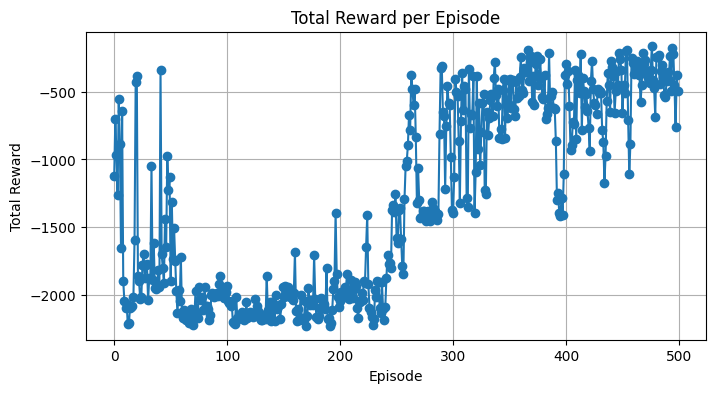

In [ ]:
# ------------------------------
# 8. Plotting and Analysis
# ------------------------------

# Plot Total Reward per Episode
plt.figure(figsize=(8,4))
plt.plot(episode_rewards, marker='o')
plt.title("Total Reward per Episode")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.grid(True)
plt.show()


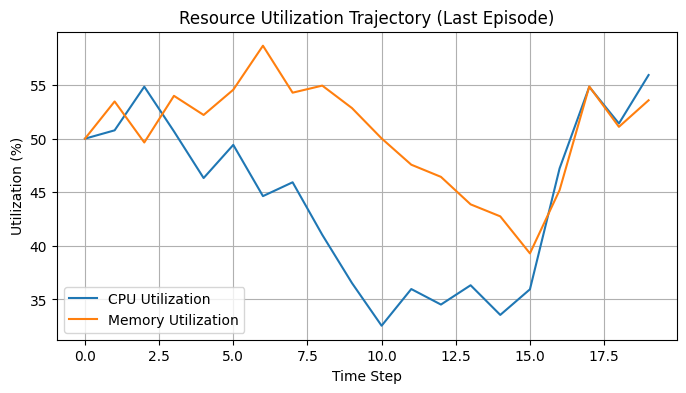

In [ ]:

# Use the last episode for detailed plotting
last_episode_states = all_episode_states[-1]
last_episode_actions = all_episode_actions[-1]
last_episode_step_rewards = all_episode_rewards[-1]
last_episode_costs = all_episode_costs[-1]

# Plot CPU and Memory Utilization over Time (Last Episode)
plt.figure(figsize=(8,4))
plt.plot(last_episode_states[:, 0], label="CPU Utilization")
plt.plot(last_episode_states[:, 1], label="Memory Utilization")
plt.xlabel("Time Step")
plt.ylabel("Utilization (%)")
plt.title("Resource Utilization Trajectory (Last Episode)")
plt.legend()
plt.grid(True)
plt.show()

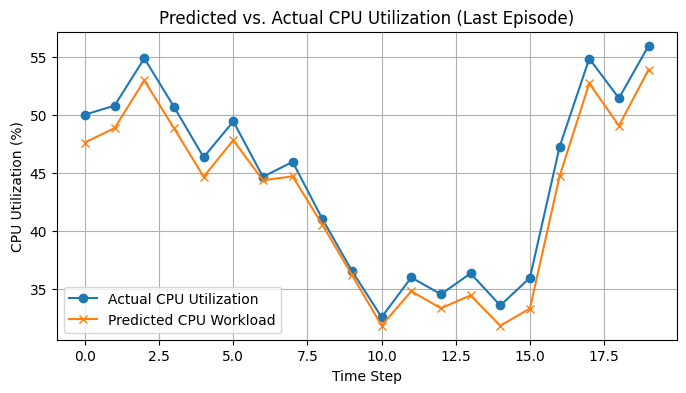

In [ ]:

# Plot Predicted Workload vs. Actual CPU for the Last Episode
predicted_cpu = workload_predictor.predict(last_episode_states, verbose=0).flatten()
plt.figure(figsize=(8,4))
plt.plot(last_episode_states[:, 0], label="Actual CPU Utilization", marker='o')
plt.plot(predicted_cpu, label="Predicted CPU Workload", marker='x')
plt.xlabel("Time Step")
plt.ylabel("CPU Utilization (%)")
plt.title("Predicted vs. Actual CPU Utilization (Last Episode)")
plt.legend()
plt.grid(True)
plt.show()

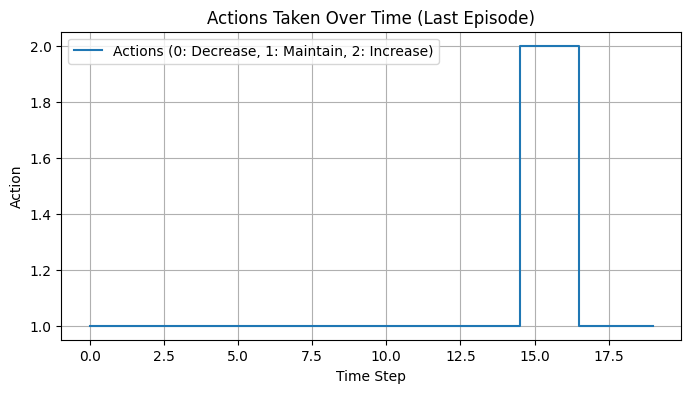

In [ ]:

# Plot Actions Taken over Time (Last Episode)
plt.figure(figsize=(8,4))
plt.step(range(len(last_episode_actions)), last_episode_actions, where='mid', label="Actions (0: Decrease, 1: Maintain, 2: Increase)")
plt.xlabel("Time Step")
plt.ylabel("Action")
plt.title("Actions Taken Over Time (Last Episode)")
plt.legend()
plt.grid(True)
plt.show()


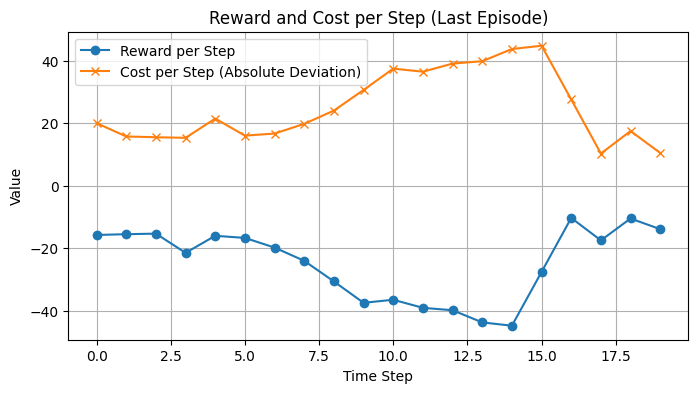

In [ ]:

# Plot Reward and Cost per Step (Last Episode)
plt.figure(figsize=(8,4))
plt.plot(last_episode_step_rewards, marker='o', label="Reward per Step")
plt.plot(last_episode_costs, marker='x', label="Cost per Step (Absolute Deviation)")
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.title("Reward and Cost per Step (Last Episode)")
plt.legend()
plt.grid(True)
plt.show()
